In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [2]:
import numpy as np
import pandas as pd
from sklearn.experimental import enable_halving_search_cv
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import train_test_split, HalvingGridSearchCV, HalvingRandomSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder

# Data prep
Load the data, perform exploratory data analysis, and process it for feeding into ML models.

## Load data

In [187]:
# load data
df_train = pd.read_csv('/kaggle/input/titanic/train.csv')
df_test = pd.read_csv('/kaggle/input/titanic/test.csv')

df_train.columns = df_train.columns.str.lower()
df_test.columns = df_test.columns.str.lower()

## Create features
Extract additional information from the data by creating features.

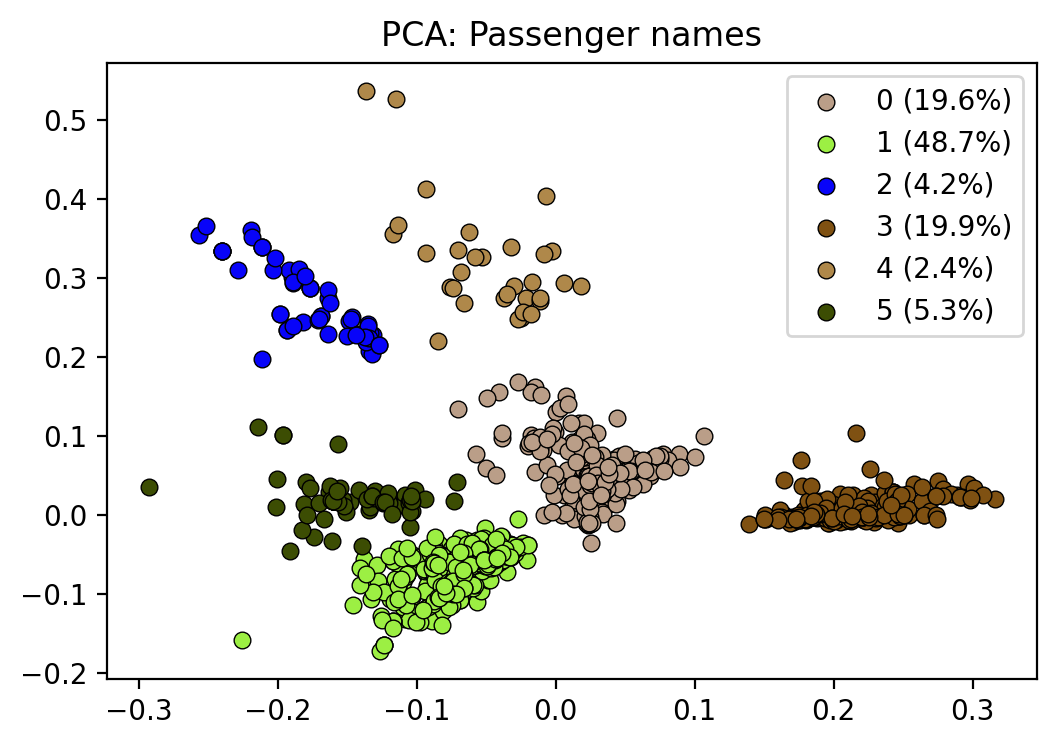

In [151]:
import random

import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

NUM_CLUSTERS = 6

names = pd.concat([df_train['name'], df_test['name']], axis=0, ignore_index=True).str.lower()
tfidf = TfidfVectorizer()
names_vec = tfidf.fit_transform(names)

pca = PCA(n_components=2)
names_pca = pca.fit_transform(names_vec.toarray())

km = KMeans(n_clusters=NUM_CLUSTERS, n_init=10)
km.fit(names_pca)

df_names = pd.DataFrame(
    {
        'x': names_pca[:, 0].reshape(-1),
        'y': names_pca[:, 1].reshape(-1),
        'label': km.labels_
    }
)
label_dist = df_names.label.value_counts(normalize=True)
# with pd.option_context('display.float_format', '{:,.1%}'.format):
#     print('Label distribution:\n', label_dist, sep='')
colors = dict(
    zip(
        df_names.label.unique(),
        random.choices(
            list(mpl.colors.XKCD_COLORS),
            k=min(NUM_CLUSTERS, df_names.label.nunique())
        )
    )
)
fig, ax = plt.subplots(figsize=(6, 4), dpi=200)
for i in sorted(df_names.label.unique()):
    ax.scatter(
        x=df_names.query(f"label == {i}")['x'],
        y=df_names.query(f"label == {i}")['y'],
#         s=df_names.query(f"label == {i}").groupby('label').transform('size'),
        c=colors[i],
        edgecolor='black',
        linewidth=0.5,
        label=f"{i} ({label_dist[i]:,.1%})"
    )
ax.set_title('PCA: Passenger names')
ax.legend()
plt.show()

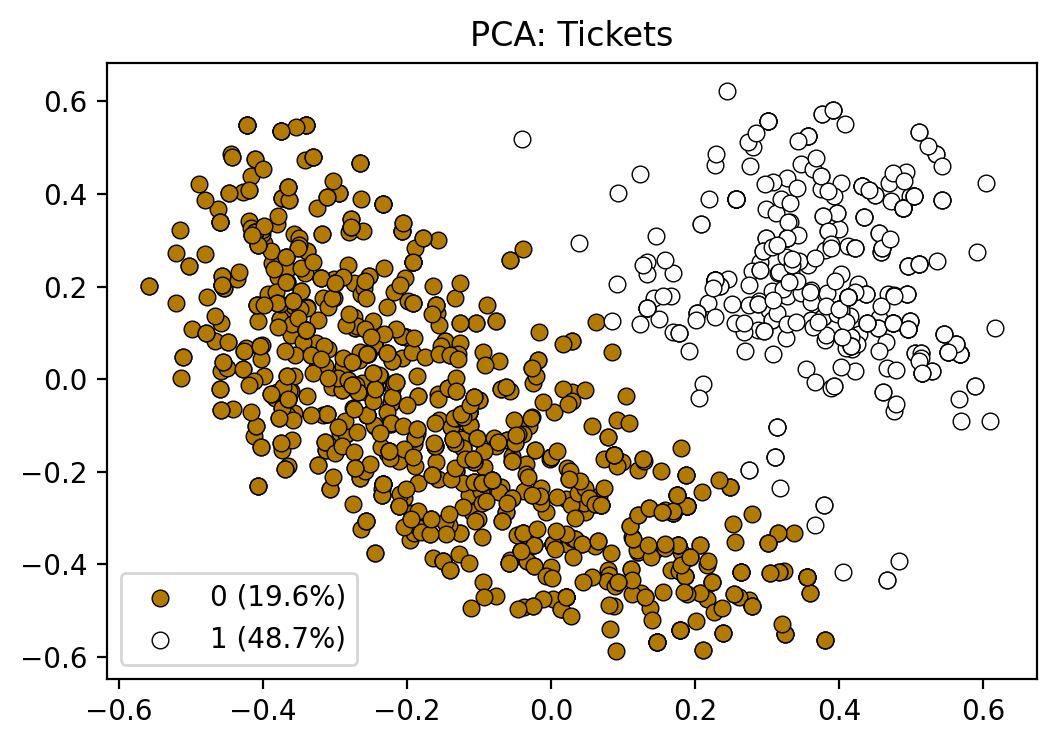

In [159]:
NUM_CLUSTERS = 2

tickets = pd.concat([df_train['ticket'], df_test['ticket']], axis=0, ignore_index=True).str.lower()
tfidf_t = TfidfVectorizer(analyzer='char', strip_accents='ascii')
tickets_vec = tfidf_t.fit_transform(tickets)

pca_t = PCA(n_components=2)
tickets_pca = pca_t.fit_transform(tickets_vec.toarray())

km_t = KMeans(n_clusters=NUM_CLUSTERS, n_init=10)
km_t.fit(tickets_pca)

df_tickets = pd.DataFrame(
    {
        'x': tickets_pca[:, 0].reshape(-1),
        'y': tickets_pca[:, 1].reshape(-1),
        'label': km_t.labels_
    }
)
label_dist_t = df_tickets.label.value_counts(normalize=True)
# with pd.option_context('display.float_format', '{:,.1%}'.format):
#     print('Label distribution:\n', label_dist, sep='')
colors = dict(
    zip(
        df_tickets.label.unique(),
        random.choices(
            list(mpl.colors.XKCD_COLORS),
            k=min(NUM_CLUSTERS, df_tickets.label.nunique())
        )
    )
)
fig, ax = plt.subplots(figsize=(6, 4), dpi=200)
for i in sorted(df_tickets.label.unique()):
    ax.scatter(
        x=df_tickets.query(f"label == {i}")['x'],
        y=df_tickets.query(f"label == {i}")['y'],
#         s=df_tickets.query(f"label == {i}").groupby('label').transform('size'),
        c=colors[i],
        edgecolor='black',
        linewidth=0.5,
        label=f"{i} ({label_dist[i]:,.1%})"
    )
ax.set_title('PCA: Tickets')
ax.legend()
plt.show()

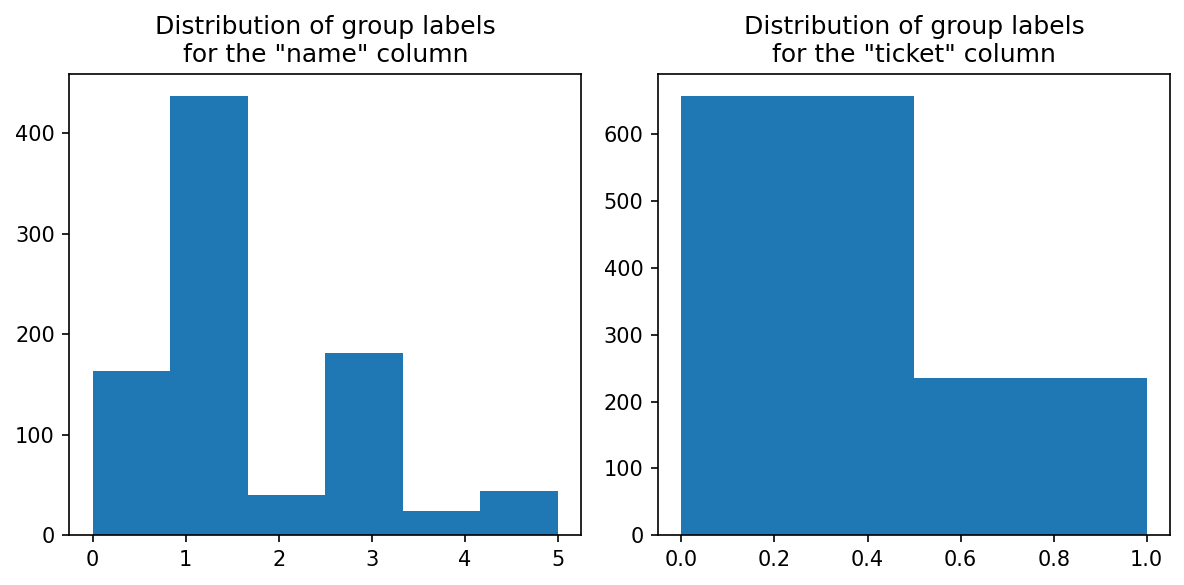

In [162]:
from sklearn.preprocessing import FunctionTransformer
pipe_name_labels = Pipeline(
    [
        ('tfidf', tfidf),
        ('toarray', FunctionTransformer(func=lambda x: x.toarray())),
        ('pca', pca),
        ('kmeans', FunctionTransformer(func=lambda x: km.transform(x))),
        ('argmin', FunctionTransformer(func=lambda x: x.argmin(axis=1)))
    ]
)

pipe_ticket_labels = Pipeline(
    [
        ('tfidf', tfidf_t),
        ('toarray', FunctionTransformer(func=lambda x: x.toarray())),
        ('pca', pca_t),
        ('kmeans', FunctionTransformer(func=lambda x: km_t.transform(x))),
        ('argmin', FunctionTransformer(func=lambda x: x.argmin(axis=1)))
    ]
)

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(8, 4), dpi=150)
axs[0].hist(pipe_name_labels.transform(df_train['name'].str.lower()), bins=len(np.unique(km.labels_)))
axs[0].set_title('Distribution of group labels\nfor the "name" column')
axs[1].hist(pipe_ticket_labels.transform(df_train['ticket'].str.lower()), bins=len(np.unique(km_t.labels_)))
axs[1].set_title('Distribution of group labels\nfor the "ticket" column')
plt.tight_layout()
plt.show()

In [194]:
# Add labels from TFIDF vectorizing with 
df_train['name_pca'] = pipe_name_labels.transform(df_train['name'].str.lower())
df_test['name_pca'] = pipe_name_labels.transform(df_test['name'].str.lower())

# Add labels from TFIDF vectorizing with 
df_train['ticket_pca'] = pipe_ticket_labels.transform(df_train['ticket'].str.lower())
df_test['ticket_pca'] = pipe_ticket_labels.transform(df_test['ticket'].str.lower())

# Replace cabin class
df_train['cabin_category'] = df_train['cabin'].str[:1].astype(pd.CategoricalDtype())
df_test['cabin_category'] = df_test['cabin'].str[:1].astype(pd.CategoricalDtype())

# Convert to better dtypes
df_train = df_train.astype(dtype={
    'pclass': pd.CategoricalDtype(categories=[1, 2, 3], ordered=True),
    'sex': pd.CategoricalDtype(categories=['male', 'female']),
#     'cabin': pd.CategoricalDtype(),
    'embarked': pd.CategoricalDtype(),
    'name_pca': pd.CategoricalDtype(),
    'ticket_pca': pd.CategoricalDtype(),
})

df_test = df_test.astype(dtype={
    'pclass': pd.CategoricalDtype(categories=[1, 2, 3], ordered=True),
    'sex': pd.CategoricalDtype(categories=['male', 'female']),
#     'cabin': pd.CategoricalDtype(),
    'embarked': pd.CategoricalDtype(),
    'name_pca': pd.CategoricalDtype(),
    'ticket_pca': pd.CategoricalDtype(),
})

print(df_train.dtypes)
df_train.head()

passengerid          int64
survived             int64
pclass            category
name                object
sex               category
age                float64
sibsp                int64
parch                int64
ticket              object
fare               float64
cabin               object
embarked          category
name_pca          category
ticket_pca        category
cabin_category    category
dtype: object


,passengerid,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,name_pca,ticket_pca,cabin_category
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,1,1,NaN
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,0,1,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,3,1,NaN
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,0,0,C
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,2,0,NaN


In [195]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(df_train.drop(columns='survived'), df_train['survived'], test_size=0.2)
print(f"Training set: {X_train.shape}, target: {y_train.shape}\nValidation set: {X_val.shape}, target: {y_val.shape}")

Training set: (712, 14), target: (712,)
Validation set: (179, 14), target: (179,)


In [196]:
df_train.dtypes

passengerid          int64
survived             int64
pclass            category
name                object
sex               category
age                float64
sibsp                int64
parch                int64
ticket              object
fare               float64
cabin               object
embarked          category
name_pca          category
ticket_pca        category
cabin_category    category
dtype: object

## Build model
I'll use `scikit-learn`'s `HistGradientBoostingClassifier`, which is a tree-based GBM inspired by LightGBM.

In [237]:
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.pipeline import make_pipeline

categorical_cols = df_train.select_dtypes(include='category').columns.tolist()

model = make_pipeline(
    ColumnTransformer(
        transformers=[
            ("categorical",
                 OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan),
                 make_column_selector(dtype_include=['category'])
            ),
            ("numeric", FunctionTransformer(func=lambda x: x), make_column_selector(dtype_include=['number']))
        ],
        remainder="drop",
        verbose_feature_names_out=False,
    ),
    HistGradientBoostingClassifier(
        categorical_features=categorical_cols,
        l2_regularization=0.1,
        max_depth=4,
        min_samples_leaf=10,
        verbose=0,
    ),
).set_output(transform="pandas")

model.fit(X_train, y_train)

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_function_transformer.py:343: UserWarning: With transform="pandas", `func` should return a DataFrame to follow the set_output API.
  warnings.warn(


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('categorical',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=nan),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7c573bb31ae0>),
                                                 ('numeric',
                                                  FunctionTransformer(func=<function <lambda> at 0x7c575f7dd900>),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7c573b2cdc60>)],
                                   verbose_feature_names_out=False)),
                ('histgradientboostingclassifier',
                 HistGradientBoostingClassifier(categorical_features=['pclass',
                                                                      'sex',
                                                                      'embarked',
                                                                      'name_pca',
                                                                      'ticket_pca',
                                                                      'cabin_category'],
                                                l2_regularization=0.1,
                                                max_depth=4,
                                                min_samples_leaf=10))])

In [242]:
model.named_steps['histgradientboostingclassifier'].categorical_features

['pclass', 'sex', 'embarked', 'name_pca', 'ticket_pca', 'cabin_category']

In [238]:
model.score(X_val, y_val)

0.8100558659217877

In [225]:
model.predict(X_val)

array([1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0,
       0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0,
       1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1,
       1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,
       1, 0, 0])